In [29]:
import mxnet as mx
import time

# Select a fixed random seed for reproducibility
mx.random.seed(42)

def data_xform(data):
    """Move channel axis to the beginning, cast to float32, and normalize to [0, 1]."""
    return nd.moveaxis(data, 2, 0).astype('float32') / 255

train_data = mx.gluon.data.vision.MNIST(train=True).transform_first(data_xform)
val_data = mx.gluon.data.vision.MNIST(train=False).transform_first(data_xform)

In [30]:
import mxnet as mx
mnist = mx.test_utils.get_mnist()

In [31]:
train_x = mx.nd.array(mnist['train_data'])
train_y = mx.nd.array(mnist['train_label'])

In [32]:
train_x.shape

(60000, 1, 28, 28)

In [33]:
batch_size = 1000
train_loader = mx.gluon.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = mx.gluon.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)

In [34]:
from __future__ import print_function  # only relevant for Python 2
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn

In [35]:
def buildNet(neuronList):
    net = gluon.nn.Sequential()
    layers = len(neuronList)
    for i in range(layers):
        if i != layers:
            net.add(gluon.nn.Dense(neuronList[i], activation='relu'))
        else:
            net.add(gluon.nn.Dense(10, activation=None))
    return net

In [36]:
neuronList = [128,64]
net = buildNet(neuronList)
print(net)

# Initialize network
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)

trainer = gluon.Trainer(
    params=net.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()


Sequential(
  (0): Dense(None -> 128, Activation(relu))
  (1): Dense(None -> 64, Activation(relu))
)


# One sample - SGD

In [15]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

import numpy as np


def train_SGD(batch_size, num_epochs):
    # split training data into mini batches
    train_loader = mx.gluon.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
    #val_loader = mx.gluon.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)
    #loss = mx.nd.mean(loss_function(net(train_x), train_y))
    total_loss = []
    for epoch in range(num_epochs):
        for B_inputs, B_labels in train_loader:
            index = np.random.randint(len(B_inputs))
            inputs = B_inputs[index]
            labels = B_labels[index]
            with autograd.record():
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

            # Compute gradients by backpropagation and update the evaluation
            # metric
            loss.backward()
            metric.update(labels, outputs)

            # Update the parameters by stepping the trainer; the batch size
            # is required to normalize the gradients by `1 / batch_size`.
            trainer.step(batch_size=inputs.shape[0])
            loss = mx.nd.mean(loss_function(net(train_x), train_y))
            total_loss.append(loss.asscalar())
            
        #Print the evaluation metric and reset it for the next epoch
        name, acc = metric.get()
        print('After epoch {}: {} = {}'.format(epoch + 1, name, acc))
        metric.reset()
    
    x_axis = np.linspace(0, num_epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.show()
            

After epoch 1: accuracy = 0.7704918032786885
After epoch 2: accuracy = 0.5833333333333334
After epoch 3: accuracy = 0.6833333333333333
After epoch 4: accuracy = 0.7166666666666667
After epoch 5: accuracy = 0.6333333333333333
After epoch 6: accuracy = 0.65
After epoch 7: accuracy = 0.7333333333333333
After epoch 8: accuracy = 0.8
After epoch 9: accuracy = 0.7
After epoch 10: accuracy = 0.6166666666666667
CPU times: user 9min 39s, sys: 15.2 s, total: 9min 54s
Wall time: 2min 44s


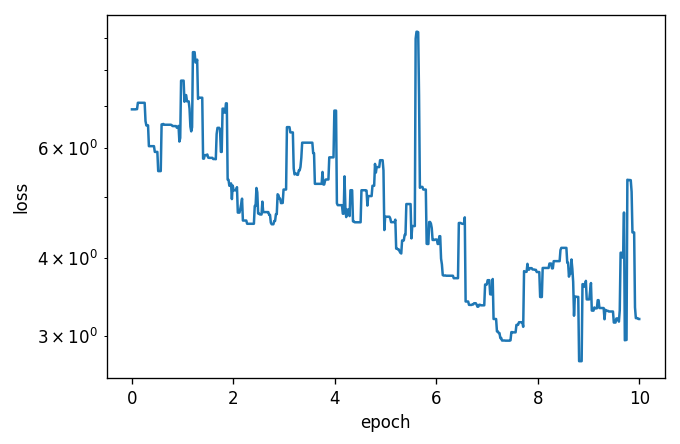

In [16]:
%time train_SGD(batch_size, 10)
plt.savefig("SGDNN_shallowNN.png")

# Mini-batch GD

In [45]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

import numpy as np



def train(batch_size, num_epochs):
    # split training data into mini batches
    train_loader = mx.gluon.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
    val_loader = mx.gluon.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)
    loss = mx.nd.mean(loss_function(net(train_x), train_y))
    total_loss = [loss.asscalar()]
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            # The forward pass and the loss computation need to be wrapped
            # in a `record()` scope to make sure the computational graph is
            # recorded in order to automatically compute the gradients
            # during the backward pass.
            with autograd.record():
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

            # Compute gradients by backpropagation and update the evaluation
            # metric
            loss.backward()
            metric.update(labels, outputs)

            # Update the parameters by stepping the trainer; the batch size
            # is required to normalize the gradients by `1 / batch_size`.
            trainer.step(batch_size=inputs.shape[0])
            loss = mx.nd.mean(loss_function(net(train_x), train_y))
            total_loss.append(loss.asscalar())
            
        # Print the evaluation metric and reset it for the next epoch
        name, acc = metric.get()
        print('After epoch {}: {} = {}'.format(epoch + 1, name, acc))
        metric.reset()
    
    x_axis = np.linspace(0, num_epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
            

After epoch 1: accuracy = 0.3947
After epoch 2: accuracy = 0.6793666666666667
After epoch 3: accuracy = 0.7480833333333333
After epoch 4: accuracy = 0.7800166666666667
After epoch 5: accuracy = 0.7993
After epoch 6: accuracy = 0.8124166666666667
After epoch 7: accuracy = 0.8233666666666667
After epoch 8: accuracy = 0.8329166666666666
After epoch 9: accuracy = 0.8385833333333333
After epoch 10: accuracy = 0.8441333333333333
CPU times: user 9min 45s, sys: 16.5 s, total: 10min 1s
Wall time: 2min 37s


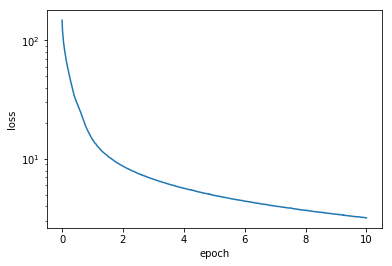

In [10]:
%time train(batch_size, 10)
plt.savefig("Mini_shallowNN.png")

# Adaptive Learning Rate
## Diminishing lr

In [39]:
neuronList = [128,64]
net = buildNet(neuronList)
print(net)

# set up the lr_scheduler
# diminishing
scheduler = mx.lr_scheduler.FactorScheduler(step=250, factor=0.5)
optim = optimizer.SGD(learning_rate=0.04, lr_scheduler=scheduler)

# Initialize network
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)

trainer = gluon.Trainer(
    params=net.collect_params(),
    optimizer=optim,
)

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

Sequential(
  (0): Dense(None -> 128, Activation(relu))
  (1): Dense(None -> 64, Activation(relu))
)


After epoch 1: accuracy = 0.3968833333333333
After epoch 2: accuracy = 0.6822833333333334
After epoch 3: accuracy = 0.7489833333333333
After epoch 4: accuracy = 0.77905
After epoch 5: accuracy = 0.7965833333333333
After epoch 6: accuracy = 0.8049666666666667
After epoch 7: accuracy = 0.8115833333333333
After epoch 8: accuracy = 0.8177666666666666
After epoch 9: accuracy = 0.8219833333333333
After epoch 10: accuracy = 0.8248
CPU times: user 10min 31s, sys: 17.6 s, total: 10min 49s
Wall time: 2min 56s


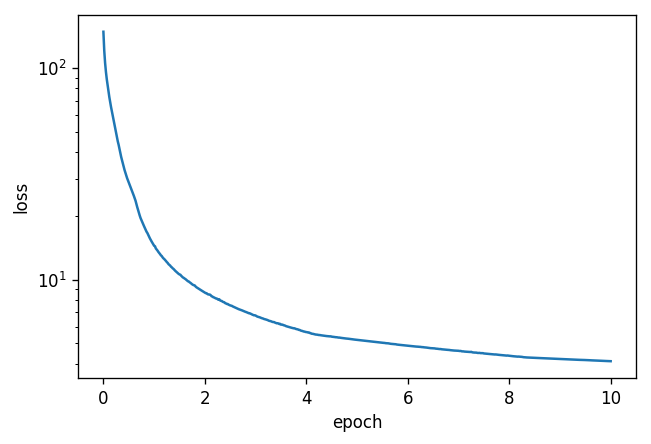

In [40]:
%time train(batch_size, 10)
plt.savefig("Mini_NN_diminishing.png")

## AdaGrad

In [41]:
neuronList = [128,64]
net = buildNet(neuronList)
print(net)

# Initialize network
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)

trainer = gluon.Trainer(
    params=net.collect_params(),
    optimizer='AdaGrad',
    optimizer_params={'learning_rate': 0.04},
)

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

Sequential(
  (0): Dense(None -> 128, Activation(relu))
  (1): Dense(None -> 64, Activation(relu))
)


After epoch 1: accuracy = 0.7042333333333334
After epoch 2: accuracy = 0.8566333333333334
After epoch 3: accuracy = 0.88
After epoch 4: accuracy = 0.8940333333333333
After epoch 5: accuracy = 0.9041833333333333
After epoch 6: accuracy = 0.9115833333333333
After epoch 7: accuracy = 0.9169333333333334
After epoch 8: accuracy = 0.9210333333333334
After epoch 9: accuracy = 0.92485
After epoch 10: accuracy = 0.92825
CPU times: user 10min 17s, sys: 17.5 s, total: 10min 35s
Wall time: 2min 49s


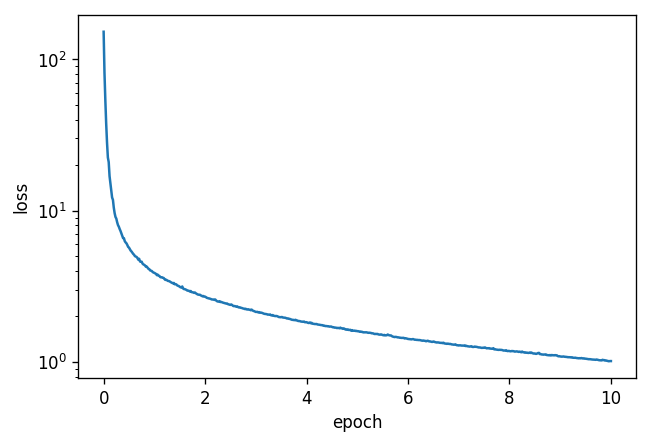

In [43]:
%time train(batch_size, 10)
plt.savefig("Mini_NN_AdaGrad.png")

## RMSProp

In [44]:
neuronList = [128,64]
net = buildNet(neuronList)
print(net)

# Initialize network
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)

trainer = gluon.Trainer(
    params=net.collect_params(),
    optimizer='RMSProp',
    optimizer_params={'learning_rate': 0.04},
)

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

Sequential(
  (0): Dense(None -> 128, Activation(relu))
  (1): Dense(None -> 64, Activation(relu))
)


After epoch 1: accuracy = 0.76775
After epoch 2: accuracy = 0.89785
After epoch 3: accuracy = 0.9237166666666666
After epoch 4: accuracy = 0.9378833333333333
After epoch 5: accuracy = 0.9502166666666667
After epoch 6: accuracy = 0.95775
After epoch 7: accuracy = 0.96215
After epoch 8: accuracy = 0.9656666666666667
After epoch 9: accuracy = 0.9704166666666667
After epoch 10: accuracy = 0.9730333333333333
CPU times: user 10min 9s, sys: 16.4 s, total: 10min 26s
Wall time: 2min 48s


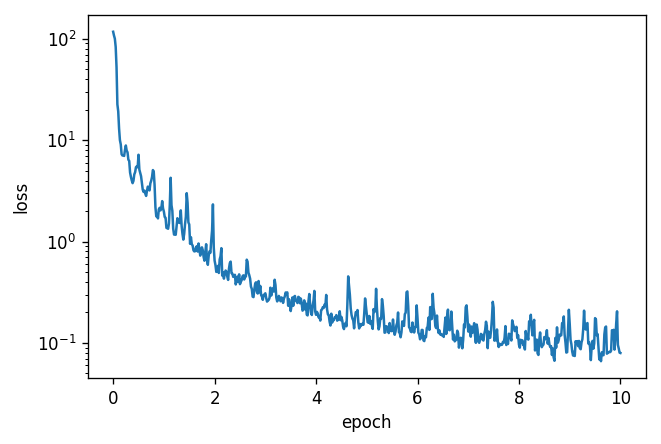

In [46]:
%time train(batch_size, 10)
plt.savefig("Mini_NN_RMSProp.png")

# Deep Network (less neurons)

In [19]:
neuronList = [128,64,32,16]
net = buildNet(neuronList)
print(net)

# Initialize network
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)

trainer = gluon.Trainer(
    params=net.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

Sequential(
  (0): Dense(None -> 128, Activation(relu))
  (1): Dense(None -> 64, Activation(relu))
  (2): Dense(None -> 32, Activation(relu))
  (3): Dense(None -> 16, Activation(relu))
)


After epoch 1: accuracy = 0.10928333333333333
After epoch 2: accuracy = 0.10458333333333333
After epoch 3: accuracy = 0.10408333333333333
After epoch 4: accuracy = 0.10458333333333333
After epoch 5: accuracy = 0.10493333333333334
After epoch 6: accuracy = 0.10538333333333333
After epoch 7: accuracy = 0.10683333333333334
After epoch 8: accuracy = 0.10761666666666667
After epoch 9: accuracy = 0.11083333333333334
After epoch 10: accuracy = 0.11255
CPU times: user 8min 51s, sys: 15.9 s, total: 9min 6s
Wall time: 2min 13s


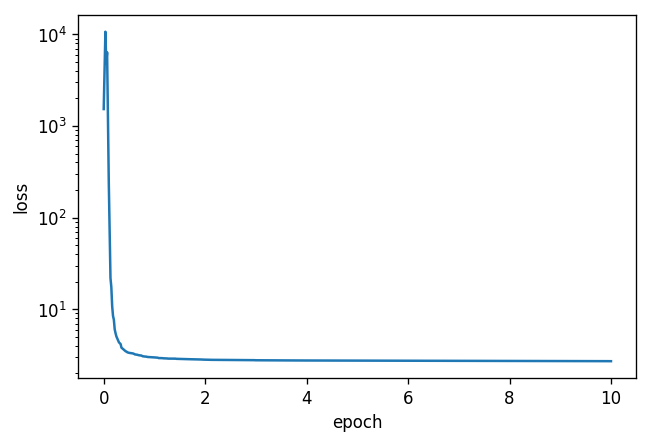

In [20]:
%time train(batch_size, 10)
plt.savefig("Mini_deepNN.png")

# Shallow Networks (more neurons)

In [21]:
neuronList = [356,128]
net = buildNet(neuronList)
print(net)

# Initialize network
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)

trainer = gluon.Trainer(
    params=net.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

Sequential(
  (0): Dense(None -> 356, Activation(relu))
  (1): Dense(None -> 128, Activation(relu))
)


After epoch 1: accuracy = 0.5359
After epoch 2: accuracy = 0.77625
After epoch 3: accuracy = 0.81805
After epoch 4: accuracy = 0.8376333333333333
After epoch 5: accuracy = 0.8509833333333333
After epoch 6: accuracy = 0.8611166666666666
After epoch 7: accuracy = 0.86825
After epoch 8: accuracy = 0.8746166666666667
After epoch 9: accuracy = 0.8798333333333334
After epoch 10: accuracy = 0.8849666666666667
CPU times: user 14min 22s, sys: 23 s, total: 14min 45s
Wall time: 4min 4s


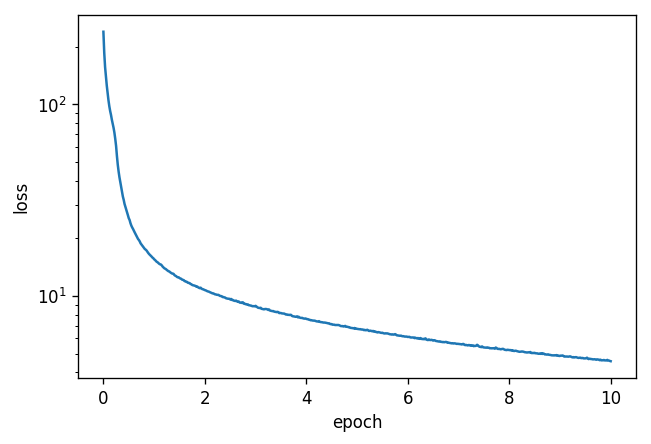

In [22]:
%time train(batch_size, 10)
plt.savefig("Mini_shallowNN.png")